# Distributed Edge AI Simulator (Colab Edition)
Configure devices & RTT → generate workload → compare offloading policies.

In [1]:

import numpy as np, pandas as pd, random, matplotlib.pyplot as plt
np.random.seed(42); random.seed(42)

ENERGY_K = 0.02

DEFAULT_DEVICES = {
    "MCU":   {"latency": {"fp32": 80, "int8": 25, "tinycnn": 7, "slm": 120}, "energy_factor": 1.0, "net_rtt": (0, 0)},
    "EDGE":  {"latency": {"fp32": 22, "int8": 10, "tinycnn": 4, "slm": 40},  "energy_factor": 1.4, "net_rtt": (5, 15)},
    "CLOUD": {"latency": {"fp32": 12, "int8": 12, "tinycnn": 12, "slm": 15}, "energy_factor": 1.9, "net_rtt": (30, 120)},
}

ACC_MATRIX = {
    "easy": {"fp32": 0.92, "int8": 0.88, "tinycnn": 0.80, "slm": 0.0},
    "hard": {"fp32": 0.86, "int8": 0.80, "tinycnn": 0.70, "slm": 0.0},
}

LM_QUALITY = {
    "short": {"slm": 0.70, "llm_cloud": 0.90},
    "long":  {"slm": 0.60, "llm_cloud": 0.92},
}

def set_int8_accuracy(measured_acc: float):
    ACC_MATRIX["easy"]["int8"] = float(max(0.0, min(1.0, measured_acc)))
    ACC_MATRIX["hard"]["int8"] = float(max(0.0, min(1.0, measured_acc - 0.05)))


In [2]:

def rnd_net_rtt(low_high):
    low, high = low_high
    if low==0 and high==0: return 0
    return random.randint(low, high)

def infer(device_name: str, model_name: str, difficulty: str, devices: dict):
    dev = devices[device_name]
    base_lat = dev["latency"].get(model_name, 999)
    rtt = rnd_net_rtt(dev["net_rtt"])
    latency = base_lat + rtt
    energy = dev["energy_factor"] * latency * ENERGY_K
    acc = ACC_MATRIX.get(difficulty, {}).get(model_name, 0.75)
    conf = float(np.clip(np.random.normal(loc=0.65 + 0.3*acc, scale=0.1), 0.01, 0.999))
    correct = (random.random() < acc)
    return correct, float(latency), float(energy), conf

def lm_infer(route: str, length: str, devices: dict):
    if route.startswith("CLOUD"):
        base = devices["CLOUD"]["latency"].get("slm", 15)
        rtt = rnd_net_rtt(devices["CLOUD"]["net_rtt"])
        latency = base + rtt + (10 if length=="long" else 5)
        energy = devices["CLOUD"]["energy_factor"] * latency * ENERGY_K
        quality = LM_QUALITY[length]["llm_cloud"]
    else:
        tier = "EDGE" if route.startswith("EDGE") else "MCU"
        base = devices[tier]["latency"].get("slm", 120)
        rtt = rnd_net_rtt(devices[tier]["net_rtt"])
        latency = base + rtt + (20 if length=="long" else 8)
        energy = devices[tier]["energy_factor"] * latency * ENERGY_K
        quality = LM_QUALITY[length]["slm"]
    correct = (random.random() < quality)
    conf = float(np.clip(np.random.normal(loc=0.6 + 0.3*quality, scale=0.1), 0.01, 0.999))
    return correct, float(latency), float(energy), conf, quality

def generate_workload(n=150, easy_ratio=0.6, deadline_range=(20,120), lm_ratio=0.25):
    rows = []
    for i in range(n):
        if random.random() < lm_ratio:
            length = "long" if random.random() < 0.4 else "short"
            deadline = random.randint(deadline_range[0]+20, deadline_range[1]+60)
            rows.append({"id": i, "type":"lm", "length": length, "difficulty": None, "deadline_ms": deadline})
        else:
            difficulty = "easy" if random.random() < easy_ratio else "hard"
            deadline = random.randint(*deadline_range)
            rows.append({"id": i, "type":"cv", "length": None, "difficulty": difficulty, "deadline_ms": deadline})
    return pd.DataFrame(rows)

def evaluate_policy(workload_df: pd.DataFrame, policy_fn, devices: dict):
    out = []
    for _, req in workload_df.iterrows():
        route, correct, latency, energy, conf = policy_fn(req, devices)
        out.append({
            "id": int(req["id"]), "type": req["type"], "route": route, "correct": bool(correct),
            "latency_ms": float(latency), "energy_mJ": float(energy), "confidence": float(conf),
            "deadline_ms": int(req["deadline_ms"]), "deadline_met": float(latency) <= float(req["deadline_ms"])
        })
    return pd.DataFrame(out)


In [3]:

def pol_always_local(req, devices):
    if req["type"]=="lm":
        route = "MCU/slm"
        correct, lat, eng, conf, _q = lm_infer(route, req["length"], devices)
        return route, correct, lat, eng, conf
    else:
        correct, lat, eng, conf = infer("MCU", "tinycnn", req["difficulty"], devices)
        return "MCU/tinycnn", correct, lat, eng, conf

def pol_always_cloud(req, devices):
    if req["type"]=="lm":
        route = "CLOUD/llm_cloud"
        correct, lat, eng, conf, _q = lm_infer(route, req["length"], devices)
        return route, correct, lat, eng, conf
    else:
        correct, lat, eng, conf = infer("CLOUD", "fp32", req["difficulty"], devices)
        return "CLOUD/fp32", correct, lat, eng, conf

def pol_conf_threshold(req, devices, thr=0.78):
    if req["type"]=="lm":
        c1, l1, e1, conf1, _q1 = lm_infer("MCU/slm", req["length"], devices)
        if conf1 >= thr:
            return "MCU/slm", c1, l1, e1, conf1
        c2, l2, e2, conf2, _q2 = lm_infer("EDGE/slm", req["length"], devices)
        if conf2 >= thr:
            return "EDGE/slm", c2, l2, e2, conf2
        c3, l3, e3, conf3, _q3 = lm_infer("CLOUD/llm_cloud", req["length"], devices)
        return "CLOUD/llm_cloud", c3, l3, e3, conf3
    else:
        c1, l1, e1, conf1 = infer("MCU", "int8", req["difficulty"], devices)
        if conf1 >= thr:
            return "MCU/int8", c1, l1, e1, conf1
        c2, l2, e2, conf2 = infer("EDGE", "fp32", req["difficulty"], devices)
        if conf2 >= thr:
            return "EDGE/fp32", c2, l2, e2, conf2
        c3, l3, e3, conf3 = infer("CLOUD", "fp32", req["difficulty"], devices)
        return "CLOUD/fp32", c3, l3, e3, conf3

def pol_latency_aware(req, devices, margin=0.9):
    if req["type"]=="lm":
        c1, l1, e1, conf1, _ = lm_infer("MCU/slm", req["length"], devices)
        if l1 <= margin * req["deadline_ms"]:
            return "MCU/slm", c1, l1, e1, conf1
        c2, l2, e2, conf2, _ = lm_infer("EDGE/slm", req["length"], devices)
        if l2 <= margin * req["deadline_ms"]:
            return "EDGE/slm", c2, l2, e2, conf2
        c3, l3, e3, conf3, _ = lm_infer("CLOUD/llm_cloud", req["length"], devices)
        return "CLOUD/llm_cloud", c3, l3, e3, conf3
    else:
        c1, l1, e1, conf1 = infer("MCU", "tinycnn", req["difficulty"], devices)
        if l1 <= margin * req["deadline_ms"]:
            return "MCU/tinycnn", c1, l1, e1, conf1
        c2, l2, e2, conf2 = infer("EDGE", "tinycnn", req["difficulty"], devices)
        if l2 <= margin * req["deadline_ms"]:
            return "EDGE/tinycnn", c2, l2, e2, conf2
        c3, l3, e3, conf3 = infer("CLOUD", "fp32", req["difficulty"], devices)
        return "CLOUD/fp32", c3, l3, e3, conf3

def pol_hybrid(req, devices, conf_thr=0.8, margin=0.85):
    if req["type"]=="lm":
        c1, l1, e1, conf1, _ = lm_infer("MCU/slm", req["length"], devices)
        if conf1 >= conf_thr and l1 <= margin * req["deadline_ms"]:
            return "MCU/slm", c1, l1, e1, conf1
        c2, l2, e2, conf2, _ = lm_infer("EDGE/slm", req["length"], devices)
        if l2 <= margin * req["deadline_ms"]:
            return "EDGE/slm", c2, l2, e2, conf2
        c3, l3, e3, conf3, _ = lm_infer("CLOUD/llm_cloud", req["length"], devices)
        return "CLOUD/llm_cloud", c3, l3, e3, conf3
    else:
        c1, l1, e1, conf1 = infer("MCU", "int8", req["difficulty"], devices)
        if conf1 >= conf_thr and l1 <= margin * req["deadline_ms"]:
            return "MCU/int8", c1, l1, e1, conf1
        c2, l2, e2, conf2 = infer("EDGE", "fp32", req["difficulty"], devices)
        if l2 <= margin * req["deadline_ms"]:
            return "EDGE/fp32", c2, l2, e2, conf2
        c3, l3, e3, conf3 = infer("CLOUD", "fp32", req["difficulty"], devices)
        return "CLOUD/fp32", c3, l3, e3, conf3


In [6]:

# Parameters (edit these)
devices = DEFAULT_DEVICES.copy()
devices["MCU"]["net_rtt"] = (0, 0)
devices["EDGE"]["net_rtt"] = (5, 15)
devices["CLOUD"]["net_rtt"] = (30, 120)

N_REQUESTS = 16
EASY_RATIO = 0.6
DEADLINE_RANGE = (20, 120)
LM_RATIO = 0.25

workload = generate_workload(n=N_REQUESTS, easy_ratio=EASY_RATIO,
                             deadline_range=DEADLINE_RANGE, lm_ratio=LM_RATIO)
workload.head()


,id,type,length,difficulty,deadline_ms
0,0,cv,None,easy,116
1,1,lm,long,None,90
2,2,lm,long,None,161
3,3,cv,None,hard,78
4,4,cv,None,hard,44


In [7]:

# Single-device trade-offs (averaged)
rows = []
for dev in devices:
    for model in ["fp32", "int8", "tinycnn"]:
        stats = {"latency": [], "energy": [], "acc": []}
        for _ in range(150):
            difficulty = "easy" if random.random() < 0.6 else "hard"
            correct, lat, eng, conf = infer(dev, model, difficulty, devices)
            stats["latency"].append(lat); stats["energy"].append(eng); stats["acc"].append(1 if correct else 0)
        rows.append({"device": dev, "model": model,
                     "avg_latency_ms": np.mean(stats["latency"]),
                     "avg_energy_mJ": np.mean(stats["energy"]),
                     "accuracy": np.mean(stats["acc"])})
tradeoffs = pd.DataFrame(rows).sort_values(["device","model"])
tradeoffs


,device,model,avg_latency_ms,avg_energy_mJ,accuracy
6,CLOUD,fp32,85.120000,3.234560,0.913333
7,CLOUD,int8,89.486667,3.400493,0.866667
8,CLOUD,tinycnn,91.006667,3.458253,0.773333
3,EDGE,fp32,32.446667,0.908507,0.920000
4,EDGE,int8,20.206667,0.565787,0.853333
5,EDGE,tinycnn,14.113333,0.395173,0.800000
0,MCU,fp32,80.000000,1.600000,0.920000
1,MCU,int8,25.000000,0.500000,0.840000
2,MCU,tinycnn,7.000000,0.140000,0.800000


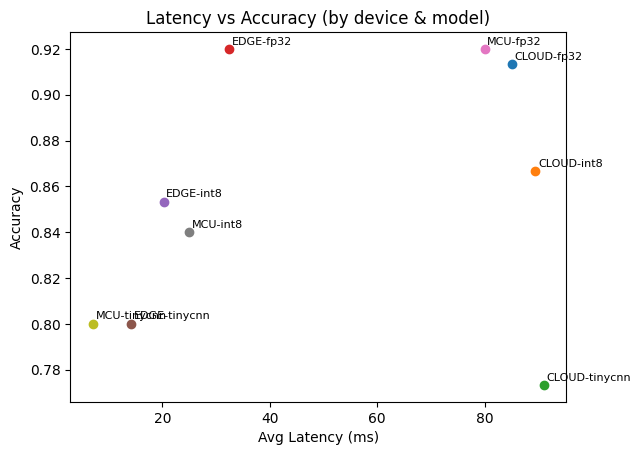

In [8]:

# Latency vs Accuracy
plt.figure()
for dev in tradeoffs["device"].unique():
    sub = tradeoffs[tradeoffs["device"] == dev]
    for _, r in sub.iterrows():
        plt.scatter(r["avg_latency_ms"], r["accuracy"])
        plt.text(r["avg_latency_ms"]+0.5, r["accuracy"]+0.002, f"{dev}-{r['model']}", fontsize=8)
plt.xlabel("Avg Latency (ms)")
plt.ylabel("Accuracy")
plt.title("Latency vs Accuracy (by device & model)")
plt.show()


In [9]:

# Evaluate policies
policies = {
    "AlwaysLocal(tinycnn)": pol_always_local,
    "AlwaysCloud(fp32/LLM)": pol_always_cloud,
    "ConfThresh(0.78)": lambda r, d: pol_conf_threshold(r, d, thr=0.78),
    "LatencyAware(0.90)": lambda r, d: pol_latency_aware(r, d, margin=0.90),
    "Hybrid(conf0.8,m0.85)": lambda r, d: pol_hybrid(r, d, conf_thr=0.8, margin=0.85),
}

results = []
for name, fn in policies.items():
    dfp = evaluate_policy(workload, fn, devices)
    dfp["policy"] = name
    results.append(dfp)
all_results = pd.concat(results, ignore_index=True)
all_results.head()


,id,type,route,correct,latency_ms,energy_mJ,confidence,deadline_ms,deadline_met,policy
0,0,cv,MCU/tinycnn,False,7.0,0.14,0.772989,116,True,AlwaysLocal(tinycnn)
1,1,lm,MCU/slm,False,140.0,2.80,0.599802,90,False,AlwaysLocal(tinycnn)
2,2,lm,MCU/slm,True,140.0,2.80,0.834146,161,True,AlwaysLocal(tinycnn)
3,3,cv,MCU/tinycnn,True,7.0,0.14,0.935916,78,True,AlwaysLocal(tinycnn)
4,4,cv,MCU/tinycnn,True,7.0,0.14,0.802349,44,True,AlwaysLocal(tinycnn)


In [10]:

summary = all_results.groupby("policy").agg(
    avg_latency_ms=("latency_ms","mean"),
    deadline_met_pct=("deadline_met","mean"),
    accuracy=("correct","mean"),
    avg_energy_mJ=("energy_mJ","mean")
).reset_index()
summary["deadline_met_pct"] = (summary["deadline_met_pct"]*100).round(1)
summary["accuracy"] = (summary["accuracy"]*100).round(1)
summary.sort_values("policy")


,policy,avg_latency_ms,deadline_met_pct,accuracy,avg_energy_mJ
0,AlwaysCloud(fp32/LLM),87.1875,31.2,100.0,3.313125
1,AlwaysLocal(tinycnn),31.1875,87.5,81.2,0.623750
2,ConfThresh(0.78),37.2500,93.8,75.0,0.823000
3,"Hybrid(conf0.8,m0.85)",36.5625,93.8,68.8,0.946250
4,LatencyAware(0.90),26.3125,93.8,81.2,0.699375


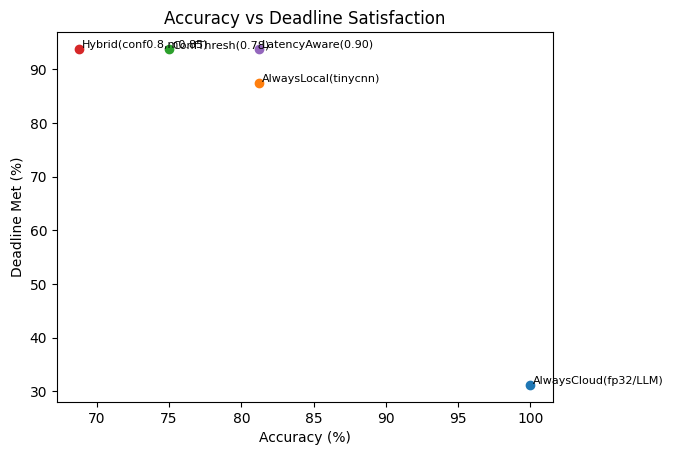

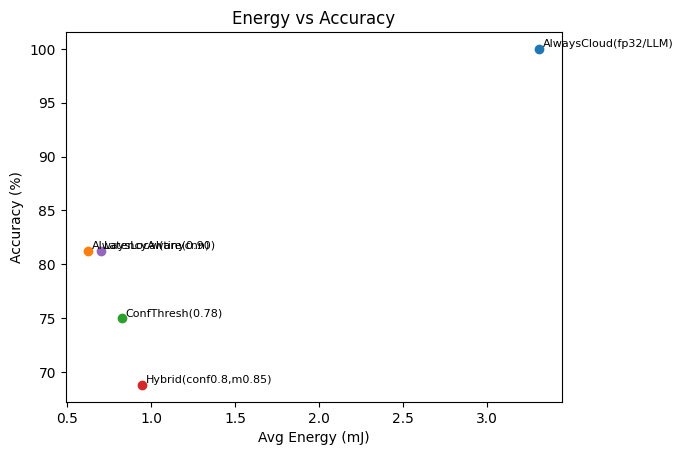

In [11]:

# Plots
plt.figure()
for _, r in summary.iterrows():
    plt.scatter(r["accuracy"], r["deadline_met_pct"])
    plt.text(r["accuracy"]+0.2, r["deadline_met_pct"]+0.2, r["policy"], fontsize=8)
plt.xlabel("Accuracy (%)")
plt.ylabel("Deadline Met (%)")
plt.title("Accuracy vs Deadline Satisfaction")
plt.show()

plt.figure()
for _, r in summary.iterrows():
    plt.scatter(r["avg_energy_mJ"], r["accuracy"])
    plt.text(r["avg_energy_mJ"]+0.02, r["accuracy"]+0.2, r["policy"], fontsize=8)
plt.xlabel("Avg Energy (mJ)")
plt.ylabel("Accuracy (%)")
plt.title("Energy vs Accuracy")
plt.show()


In [13]:

# Your policy
def my_policy(req, devices):
    if req["type"]=="lm":
        c1, l1, e1, conf1, _ = lm_infer("MCU/slm", req["length"], devices)
        if conf1 >= 0.8 and l1 <= 0.85 * req["deadline_ms"]:
            return "MCU/slm", c1, l1, e1, conf1
        c2, l2, e2, conf2, _ = lm_infer("EDGE/slm", req["length"], devices)
        if l2 <= 0.95 * req["deadline_ms"]:
            return "EDGE/slm", c2, l2, e2, conf2
        c3, l3, e3, conf3, _ = lm_infer("CLOUD/llm_cloud", req["length"], devices)
        return "CLOUD/llm_cloud", c3, l3, e3, conf3
    else:
        c1, l1, e1, conf1 = infer("MCU", "int8", req["difficulty"], devices)
        if conf1 >= 0.8 and l1 <= 0.85 * req["deadline_ms"]:
            return "MCU/int8", c1, l1, e1, conf1
        c2, l2, e2, conf2 = infer("EDGE", "fp32", req["difficulty"], devices)
        if l2 <= 0.95 * req["deadline_ms"]:
            return "EDGE/fp32", c2, l2, e2, conf2
        c3, l3, e3, conf3 = infer("CLOUD", "fp32", req["difficulty"], devices)
        return "CLOUD/fp32", c3, l3, e3, conf3

my_res = evaluate_policy(workload, my_policy, devices)
my_summary = my_res.agg(
    avg_latency_ms=("latency_ms","mean"),
    deadline_met_pct=("deadline_met","mean"),
    accuracy=("correct","mean"),
    avg_energy_mJ=("energy_mJ","mean")
).T
my_summary["deadline_met_pct"] = (my_summary["deadline_met_pct"]*100).round(1)
my_summary["accuracy"] = (my_summary["accuracy"]*100).round(1)
my_summary


,avg_latency_ms,deadline_met_pct,accuracy,avg_energy_mJ
latency_ms,36.8125,NaN,NaN,NaN
deadline_met,NaN,93.8,NaN,NaN
correct,NaN,NaN,75.0,NaN
energy_mJ,NaN,NaN,NaN,0.9495


### Optional: paste your INT8 accuracy
If you ran the training notebook, apply it here:

```python
# set_int8_accuracy(0.875)
```